In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score

import sys
sys.path.insert(0, "../")

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [2]:
from data_iq.dataiq_class import *
from src.utils.data_loader import *
from src.utils.exp3_helpers import *


In [3]:
X_trains, y_trains, X_tests, y_tests = get_data(dataset="seer")
X_trainc, y_trainc, X_testc, y_testc = get_data(dataset="cutract")

logging.info(f"size of cutract = {len(y_trainc)}, seer = {len(y_trains)}")


INFO:root:size of cutract = 1000, seer = 1000


In [4]:
overall_sc = []  # SEER-CUTRACT
overall_cs = []  # CUTRACT-SEER

conf_thresh_low = 0.25
conf_thresh_high = 0.75
conf_thresh = 0.5

percentile_thresh = conf_thresh * 100

final = 11

for nest in [100, 150, 200]:
    scores_cs = []
    scores_sc = []

    #########################################################
    #
    # CUTRACT EXPERIMENT: train on Cutract, test on Seer
    #
    #########################################################
    logging.info("Running Cutract to Seer Exp...")
    # Characterize cutract dataset into subgroups with data-iq
    easy_train, ambig_train, hard_train, aleatoric_train, ids = filter_with_dataiq(
        X_trainc, y_trainc, nest
    )

    # Assess CUTRACT
    for i in range(1, 11):

        # sort based on aleatoric ambiguity
        ambig_alea = np.argsort(aleatoric_train[ambig_train])
        prop = int((i / (final - 1)) * len(ambig_alea))

        ambigs = ambig_alea[0:prop]

        # filter ids
        ids = np.concatenate((easy_train, ambigs))

        # train on sculpted data
        clf = xgb.XGBClassifier(n_estimators=nest)
        clf.fit(X_trainc.iloc[ids, :], y_trainc.values[ids])
        preds = clf.predict(X_tests)

        scores_cs.append(accuracy_score(preds, y_tests))

    #########################################################
    #
    # SEER EXPERIMENT: train on Seer, test on Cutract
    #
    #########################################################

    logging.info("Running Seer to Cutract Exp...")
    # Characterize SEER dataset into subgroups with data-iq
    easy_train, ambig_train, hard_train, aleatoric_train, ids = filter_with_dataiq(
        X_trains, y_trains, nest
    )

    for i in range(1, final, 1):

        # sort based on aleatoric ambiguity
        ambig_alea = np.argsort(aleatoric_train[ambig_train])
        prop = int((i / (final - 1)) * len(ambig_alea))

        ambigs = ambig_alea[0:prop]

        # filter ids
        ids = np.concatenate((easy_train, ambigs))

        # filter ids
        clf = xgb.XGBClassifier(n_estimators=nest)
        clf.fit(X_trains.iloc[ids, :], y_trains.values[ids])
        preds = clf.predict(X_testc)

        scores_sc.append(accuracy_score(preds, y_testc))

    overall_cs.append(scores_cs)

    overall_sc.append(scores_sc)

overall_cs = np.array(overall_cs)
overall_sc = np.array(overall_sc)


INFO:root:Running Cutract to Seer Exp...
INFO:root:Running Seer to Cutract Exp...
INFO:root:Running Cutract to Seer Exp...
INFO:root:Running Seer to Cutract Exp...
INFO:root:Running Cutract to Seer Exp...
INFO:root:Running Seer to Cutract Exp...


In [7]:
def plot_result(overall_sc, overall_cs, raw_numbers=False):
    plt.style.reload_library()
    plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])
    from scipy.signal import savgol_filter

    plt.figure(figsize=(7, 4))
    xvals = [i / 10 for i in list(range(1, 11))]

    if raw_numbers == True:
        xvals = [0.5 * 1000 * val for val in xvals]

    plt.plot(
        xvals,
        savgol_filter(np.mean(overall_sc, axis=0), 7, 2),
        label="Train US: Test UK",
    )
    plt.fill_between(
        xvals,
        savgol_filter(np.mean(overall_sc, axis=0), 7, 2) - np.std(overall_sc, axis=0),
        savgol_filter(np.mean(overall_sc, axis=0), 7, 2) + np.std(overall_sc, axis=0),
        alpha=0.2,
    )

    plt.plot(
        xvals,
        savgol_filter(np.mean(overall_cs, axis=0), 7, 2),
        label="Train UK: Test US",
    )
    plt.fill_between(
        xvals,
        savgol_filter(np.mean(overall_cs, axis=0), 7, 2) - np.std(overall_cs, axis=0),
        savgol_filter(np.mean(overall_cs, axis=0), 7, 2) + np.std(overall_cs, axis=0),
        alpha=0.2,
    )

    plt.xlabel("Proportion of Ambigious training data")
    plt.ylabel("Accuracy")
    plt.axis([max(xvals), min(xvals), 0.65, 0.73])
    plt.legend()
    plt.show()


<Figure size 4200x2400 with 0 Axes>

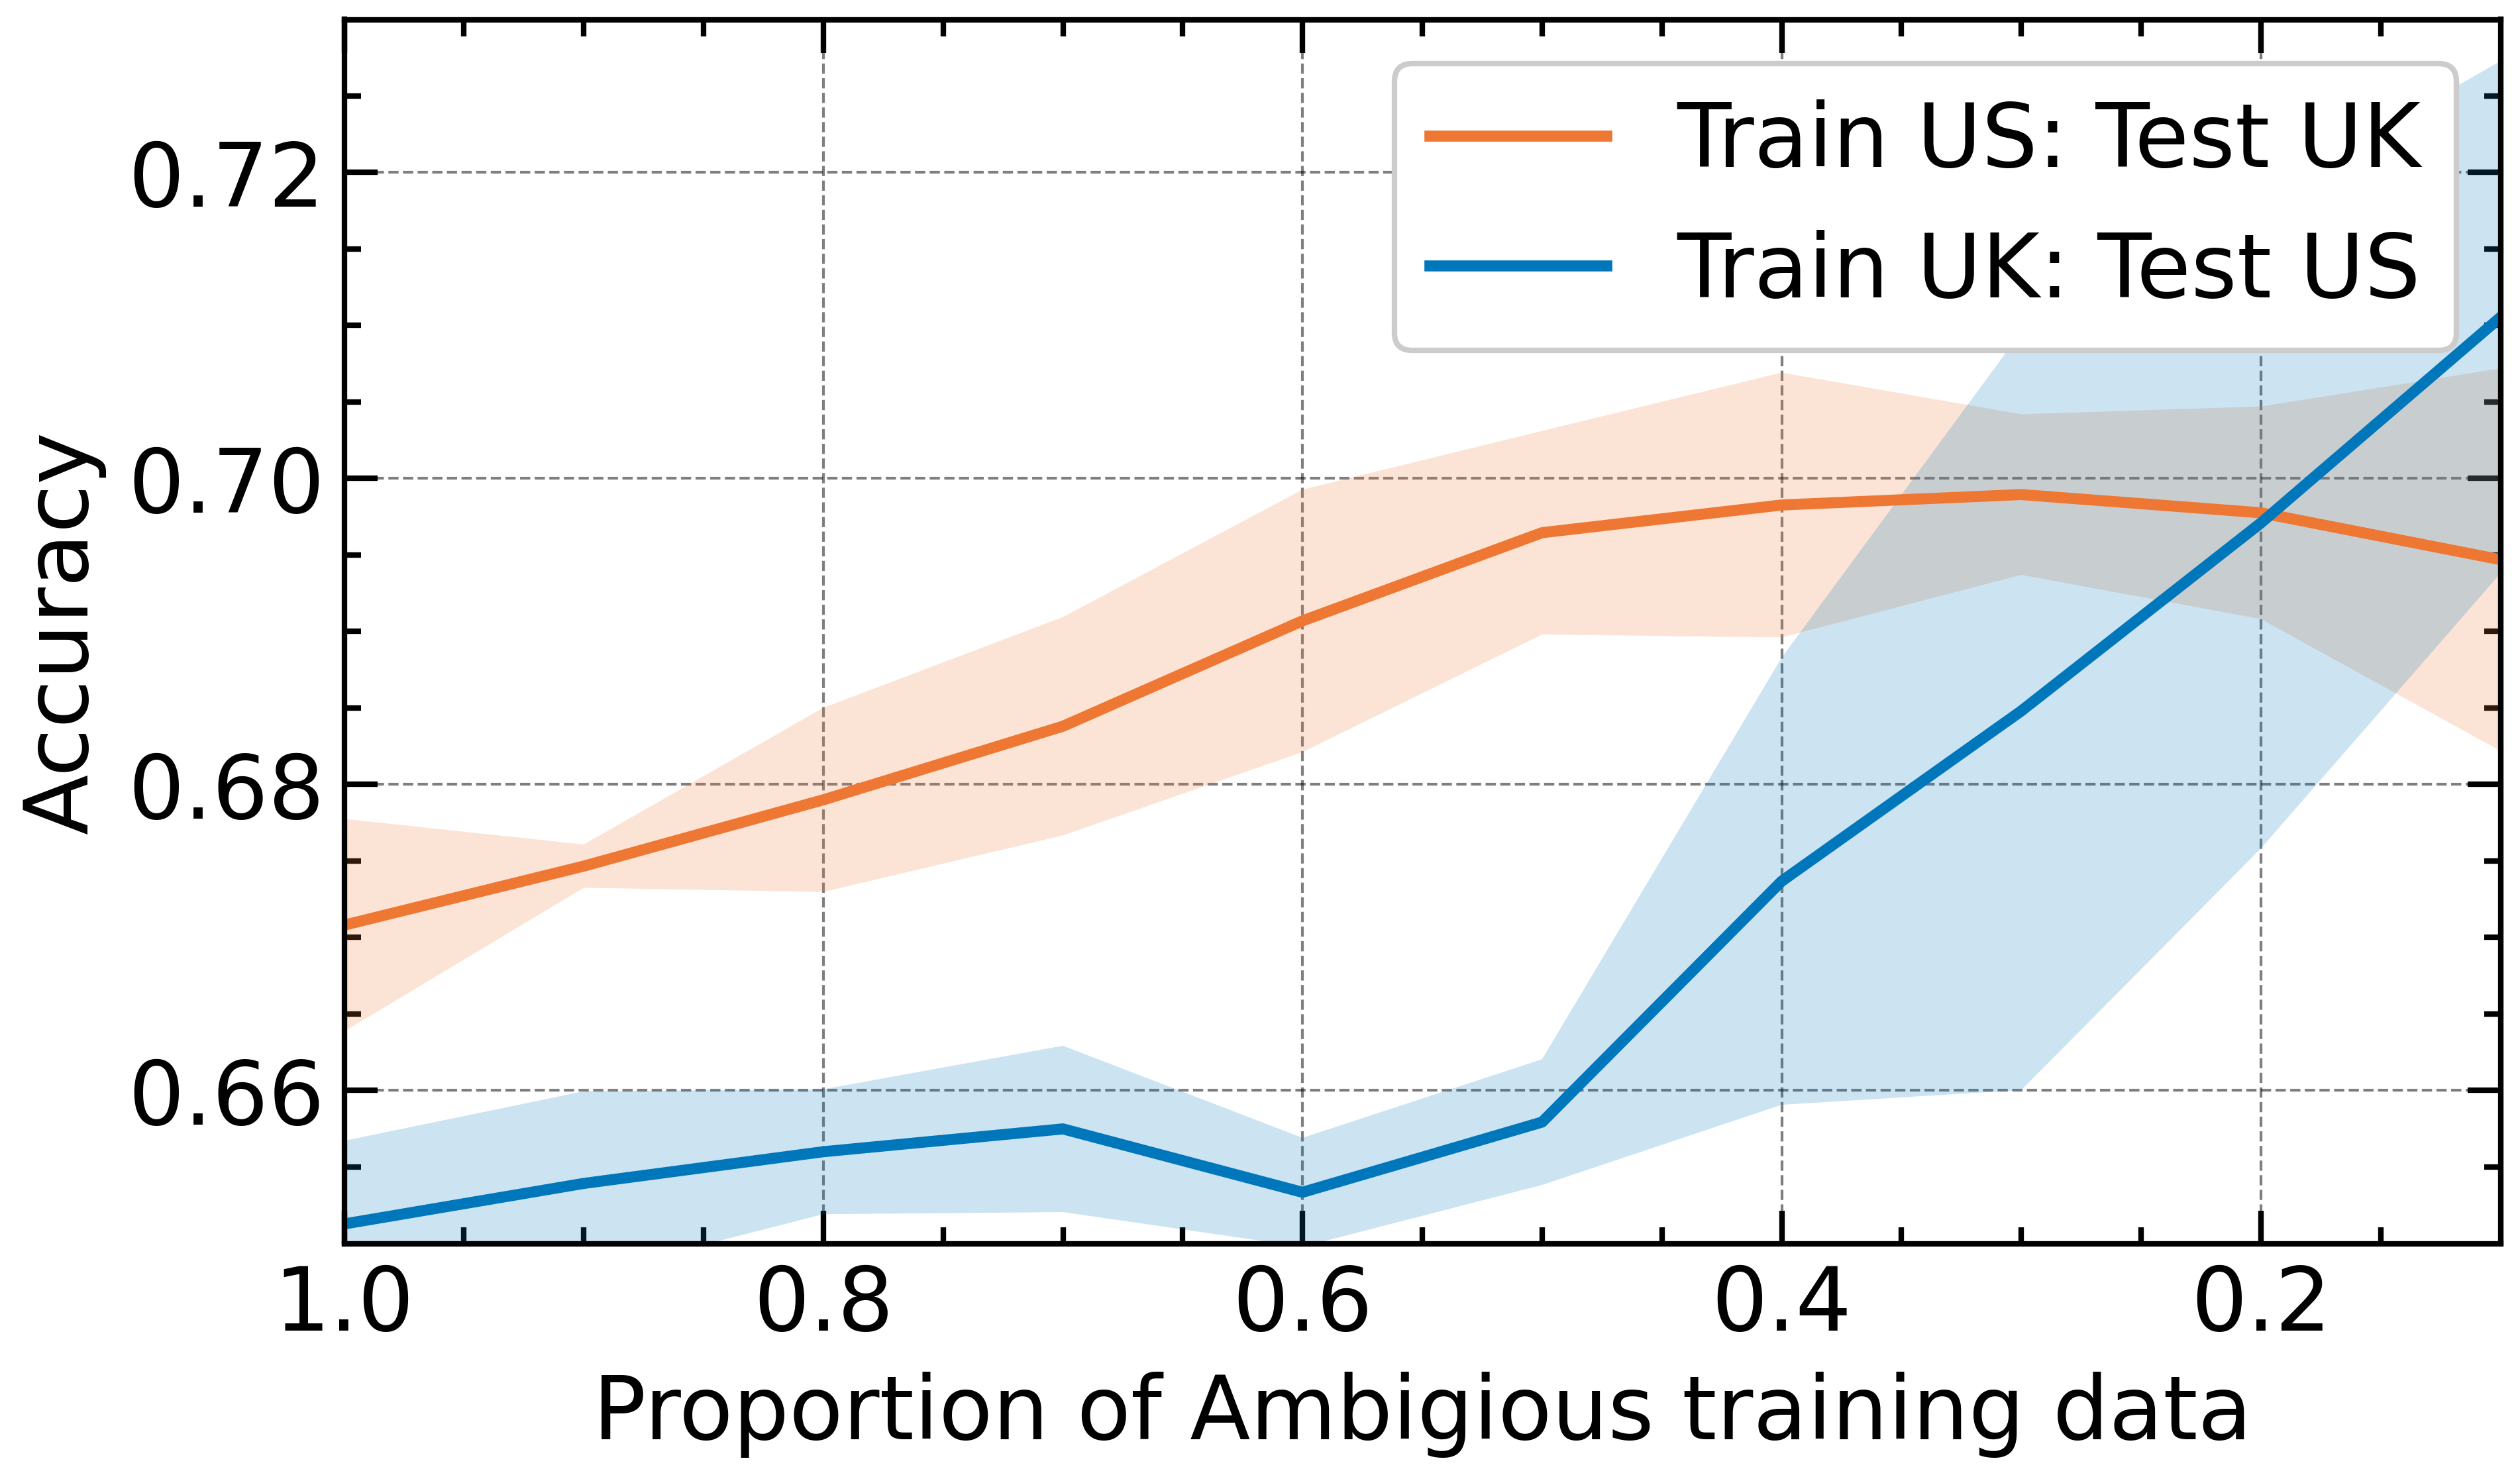

In [8]:
plot_result(overall_sc, overall_cs)


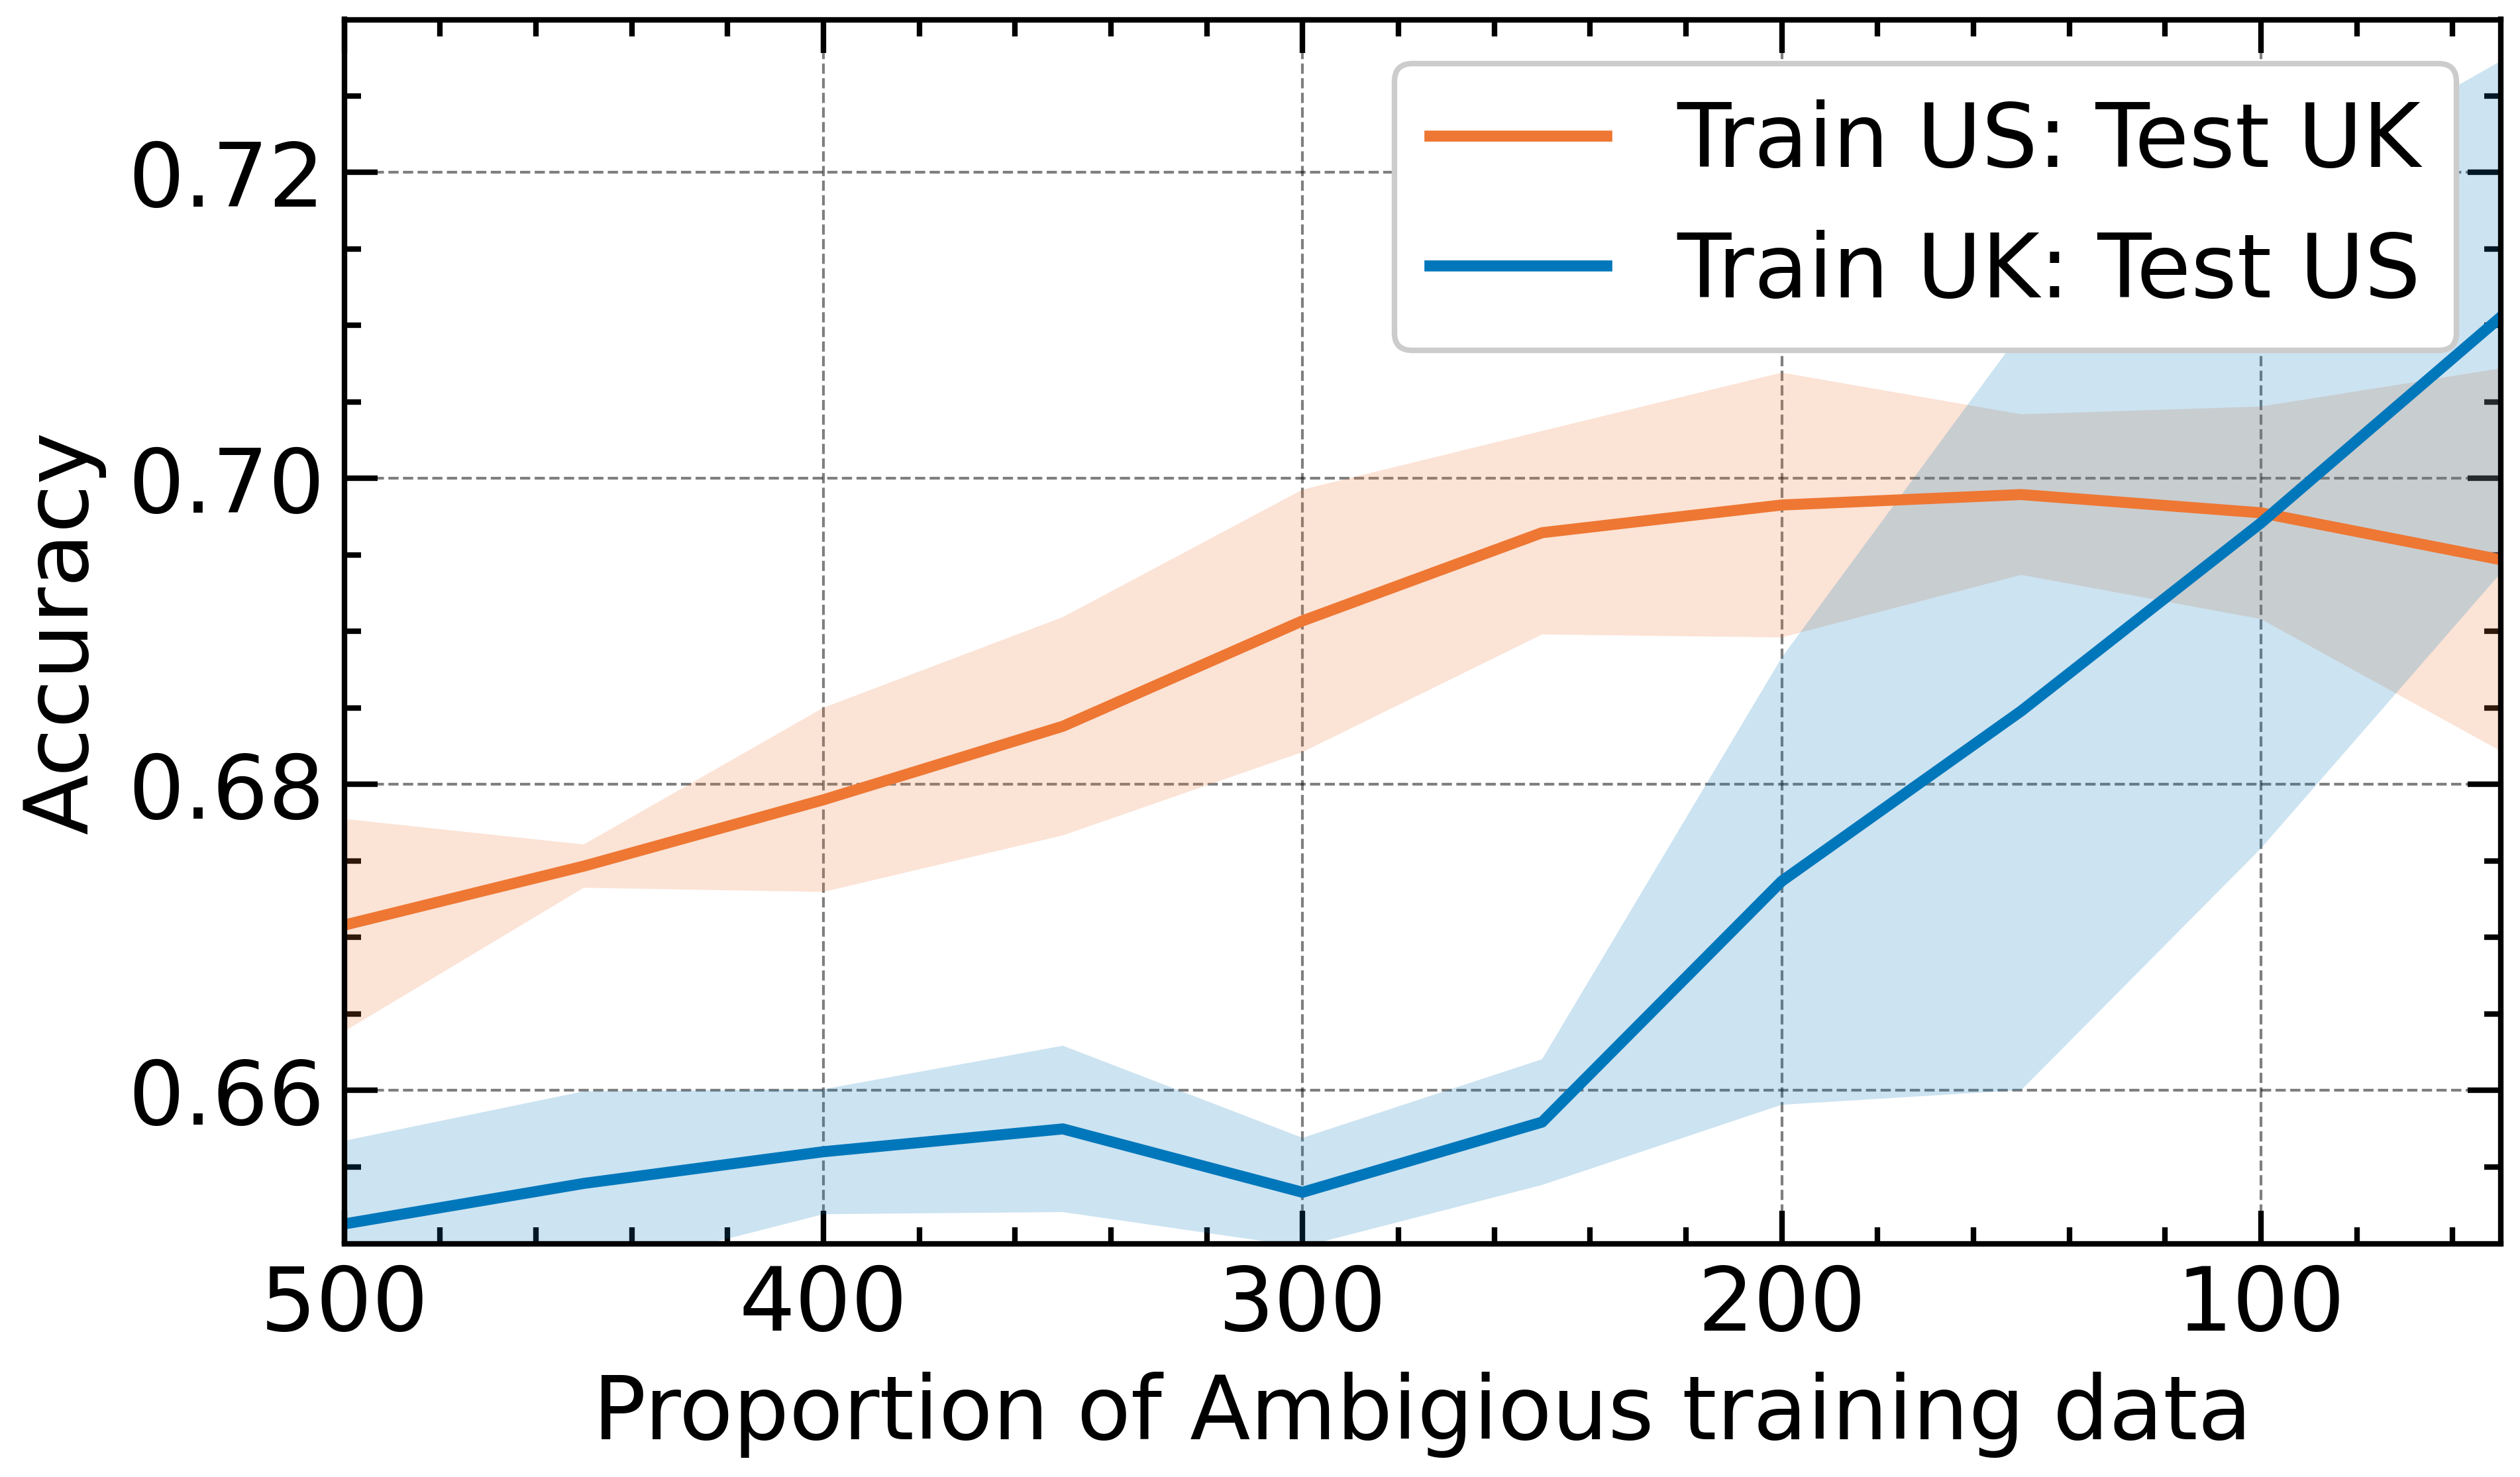

In [9]:
plot_result(overall_sc, overall_cs, raw_numbers=True)
